In [1]:
import csv
import math
import subprocess

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Trials

Let's run trials in Python from outside the Java source files. Make sure to make the jar file by running `mvn assembly:assembly` with your command line/shell of choice in the main directory first.

## Setup file reading functions

In [2]:
def read_baseline(baseline_filename):
    traversal_time = dict()
    with open(baseline_filename) as infile:
        isFirstLine = True
        vtime = dict()
        for s in infile:
            if isFirstLine:
                isFirstLine = False
            else:
                s2 = s.strip()
                d = s2.split(',')
                key = (d[3],d[4],d[5])
                if key in vtime:
                    t = abs(float(d[1])-float(vtime[key]))
                    traversal_time[key] = t
                else:
                    vtime[key] = d[1]
    return traversal_time

def read_delay(infilename, base_time):
    delay_time = dict()
    with open(infilename) as infile:
        isFirstLine = True
        vtime = dict()
        for s in infile:
            if isFirstLine:
                isFirstLine = False
            else:
                s2 = s.strip()
                d = s2.split(',')
                vin = d[0]
                t = d[1]
                key = (d[3],d[4],d[5])
                if vin in vtime:
                    traversal_time = abs(float(t)-float(vtime[vin]))
                    delay_time[vin] = traversal_time - base_time[key]
                else:
                    vtime[vin] = t
    return delay_time

def print_traversal_time(traversal_time):
    for (type,laneId,destRoad),t in traversal_time.items():
        print("[", type, ",", laneId, ",", destRoad, "] = ", t);

def avg_delay(delay_time):
	count_for_human = 0
	count_for_auto = 0
	delay_for_human = 0
	delay_for_auto = 0
	
	for vin,delay in delay_time.items():
		if (int(vin) >= 10000):
			count_for_human += 1
			delay_for_human += delay
		else:
			count_for_auto += 1
			delay_for_auto += delay

	if (count_for_human != 0):
	  avg_delay_human = delay_for_human / count_for_human
	else:
	  avg_delay_human = 0
	  
	if (count_for_auto != 0):
	  avg_delay_auto = delay_for_auto / count_for_auto
	else:
	  avg_delay_auto = 0

	if (count_for_human != 0 or count_for_auto != 0):
	  avg_delay = (delay_for_human + delay_for_auto) / (count_for_human + count_for_auto)
	else:
	  avg_delay = 0
	return [avg_delay, avg_delay_human, avg_delay_auto]

## Automate trials for a single set of parameters

In [3]:
def hhv_trial(traffic_level, hhv_proportion, buffer_factor, baseline_filename='output/baseline.csv', n=30):
    '''
    Run a HHV trial
    
    n:   how many iterations of the same trial to run
    '''
    
    base_time = read_baseline(baseline_filename)
    
    command = 'java -jar target/AIM5HHV-0.1-trb2020-jar-with-dependencies.jar -d {} {} {}'.format(traffic_level, hhv_proportion, buffer_factor)
    fileName = 'output/ts_hud_{}_{}_{}.csv'.format(traffic_level, hhv_proportion, buffer_factor)

    df = pd.DataFrame(columns=['avg_delay', 'delay_human', 'avg_delay_auto'])
    
#     with open("output/delay_result_for_human_t{}_p{}_b{}x.csv".format(traffic_level, hhv_proportion, buffer_factor), "w") as csvfile:
#         writer = csv.writer(csvfile)
    for i in range(n):
        subprocess.run(command, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        avg_delay_time = avg_delay(read_delay(fileName, base_time))
        df.loc[i] = avg_delay_time
#             writer.writerow(avg_delay_time)
            
    subprocess.run("rm {}".format(fileName), shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    
    return df

df = hhv_trial(0.1, 0.1, 4.0, n=1)
df.head()

,avg_delay,delay_human,avg_delay_auto
0,1.007098,1.081429,0.999197


## Automate trials for many parameters

In [4]:
def hhv_trials(ratio_res=0.05, buffer_res=1.0, buffer_max=16.0, n=30):
    traffic_level = 0.1
    ratios = np.arange(0.0, 1.01, ratio_res)
    buffers = np.arange(1.0, buffer_max+0.01, buffer_res)
    
    df = pd.DataFrame(columns=['ratio', 'buffer_factor', 'avg_delay', 'delay_human', 'avg_delay_auto'])
    
    for ratio in ratios:
        for buffer in buffers:
            dftemp = hhv_trial(traffic_level, ratio, buffer, n=n)
            dftemp['ratio'] = ratio
            dftemp['buffer_factor'] = buffer
            df = pd.concat([df, dftemp], ignore_index=True, sort=False)
    
    return df

try:
    df = pd.read_csv("output/delay_all_trials.csv")
except FileNotFoundError:
    df = hhv_trials()
    df.to_csv("output/delay_all_trials.csv", index=False)
df.sample(5)

,ratio,buffer_factor,avg_delay,delay_human,avg_delay_auto
187,0.60,8.0,3.012482,3.325576,2.547179
124,0.40,5.0,1.099057,1.105616,1.094417
139,0.45,5.0,1.219783,1.287925,1.164512
4,0.00,5.0,1.119932,0.000000,1.119932
100,0.30,11.0,2.606726,3.364751,2.284686


## Visualize results

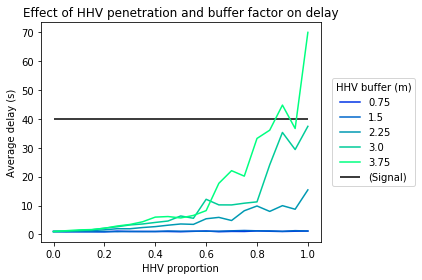

In [73]:
def plot_hhv_trials(df):
    cm = plt.get_cmap('winter')

    gs = df.groupby('buffer_factor')
    colorcap = max(gs.groups.keys())
    for buffer_factor, gbf in gs:
        if (buffer_factor)%3==0:
            agg = gbf.groupby('ratio').mean()
            plt.plot(agg.index[::-1], agg['avg_delay'][::-1], label=buffer_factor*.25, c=cm(buffer_factor/colorcap))
    plt.hlines(40, 0, 1, colors='k', label='(Signal)')
    plt.ylabel('Average delay (s)')
    plt.xlabel('HHV proportion')
    plt.title('Effect of HHV penetration and buffer factor on delay')
    plt.legend(title='HHV buffer (m)', bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    plt.tight_layout()
    plt.savefig('output/HHVpen.png', dpi='figure')
    plt.show()
plot_hhv_trials(df)

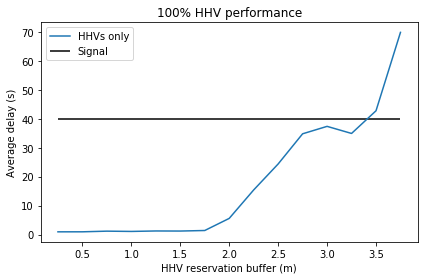

In [74]:
def plot_100pc_HHV_case(df):
    dft = df[df['ratio']==1].groupby('buffer_factor').mean()
    xs = dft.index*.25
    plt.plot(xs,dft['avg_delay'], label='HHVs only')
    plt.hlines(40, xs.min(), xs.max(), label='Signal')
    plt.xlabel('HHV reservation buffer (m)')
    plt.ylabel('Average delay (s)')
    plt.title('100% HHV performance')
    plt.legend()
    plt.tight_layout()
    plt.savefig('output/100pcHHVs.png', dpi='figure')
    plt.show()
plot_100pc_HHV_case(df)